# MACD

In [10]:
import numpy as np
import pandas as pd

# 生成126天的日收益率数据（均值为0，方差为xxx的正态分布）
np.random.seed(13)
returns = np.random.normal(0.005, 0.05, 276)

# 计算累计收益率，初始价格为1，前26天不用于绘图，但要用于EMA计算
initial_price = 1
cumulative_returns = np.cumprod(1 + returns)  # 累计收益率
close_prices = cumulative_returns * initial_price  # 收盘价

# 构建DataFrame，包含126天的收益率和收盘价
df = pd.DataFrame({'returns': returns, 'close': close_prices})

# 定义EMA (指数移动平均)
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

# 计算MACD的三个指标
# MACD Line = EMA(close, 12) - EMA(close, 26)
df['EMA_12'] = ema(df['close'], 12)
df['EMA_26'] = ema(df['close'], 26)
df['MACD_Line'] = df['EMA_12'] - df['EMA_26']

# Signal Line = EMA(MACD_Line, 9)
df['Signal_Line'] = ema(df['MACD_Line'], 9)

# MACD Histogram = MACD_Line - Signal_Line
df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']

# 截取后100天的数据用于绘图
df_plot = df.iloc[26:].copy().reset_index()


df_plot[['returns', 'close', 'MACD_Line', 'Signal_Line', 'MACD_Histogram']].head()  # 显示最终的几个值


,returns,close,MACD_Line,Signal_Line,MACD_Histogram
0,-0.076955,1.484981,0.125013,0.125119,-0.000106
1,-0.008907,1.471755,0.113013,0.122698,-0.009685
2,0.074962,1.582080,0.111124,0.120383,-0.009259
3,-0.075755,1.462229,0.098817,0.116070,-0.017253
4,0.029544,1.505428,0.091495,0.111155,-0.019660


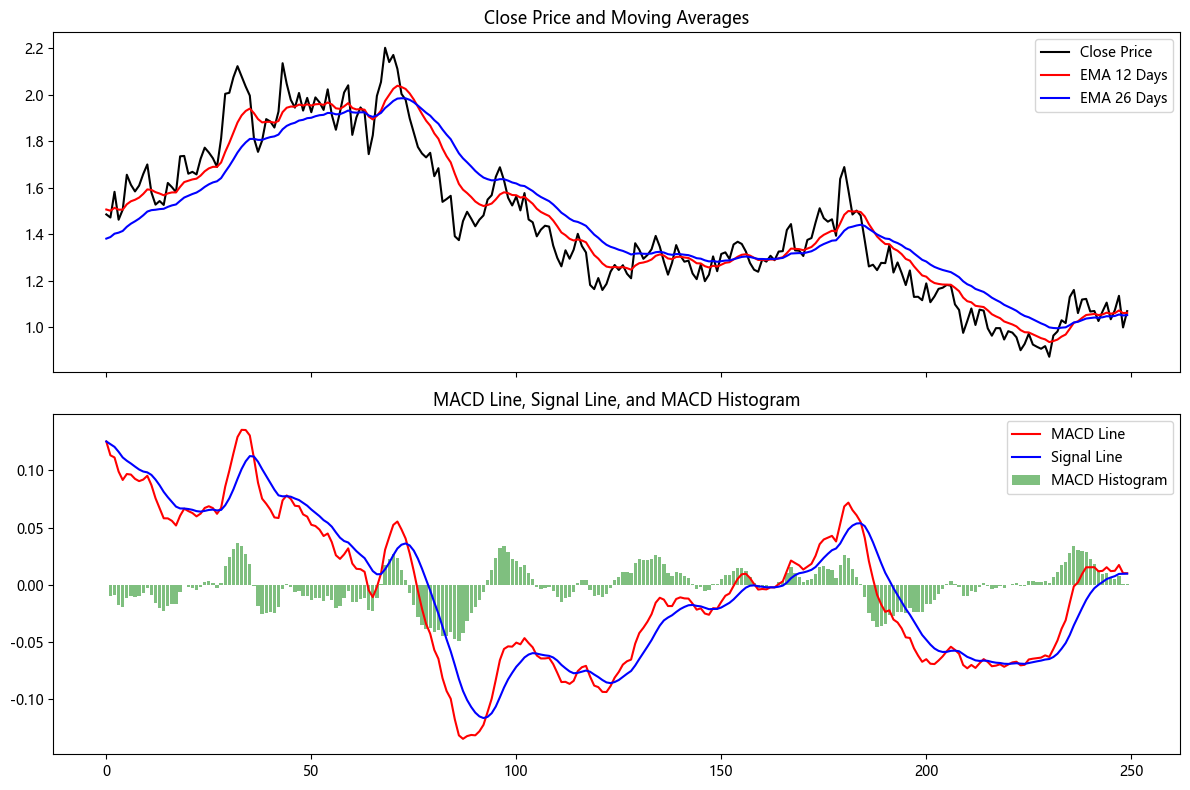

In [11]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = ['sans-serif']
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 例如，使用微软雅黑作为字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 创建图像并设置两个子图，基于更新后的100天数据绘制
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 在第一个子图上绘制收盘价和两个均线
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax1.plot(df_plot.index, df_plot['EMA_12'], label='EMA 12 Days', color='red')
ax1.plot(df_plot.index, df_plot['EMA_26'], label='EMA 26 Days', color='blue')
ax1.set_title('Close Price and Moving Averages')
ax1.legend()

# 在第二个子图上绘制MACD线、信号线和MACD柱状图
ax2.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax2.plot(df_plot.index, df_plot['Signal_Line'], label='Signal Line', color='blue')
ax2.bar(df_plot.index, df_plot['MACD_Histogram'], label='MACD Histogram', color='green', alpha=0.5)
ax2.set_title('MACD Line, Signal Line, and MACD Histogram')
ax2.legend()

# 显示图像
plt.tight_layout()
plt.show()



# 金叉死叉

In [12]:
# 计算交叉点，并添加到数据集中
df_plot['Cross'] = np.where((df_plot['MACD_Histogram'].shift(1) > 0) & (df_plot['MACD_Histogram'] <= 0), 'crossunder',
                            np.where((df_plot['MACD_Histogram'].shift(1) < 0) & (df_plot['MACD_Histogram'] >= 0), 'crossover', np.nan))


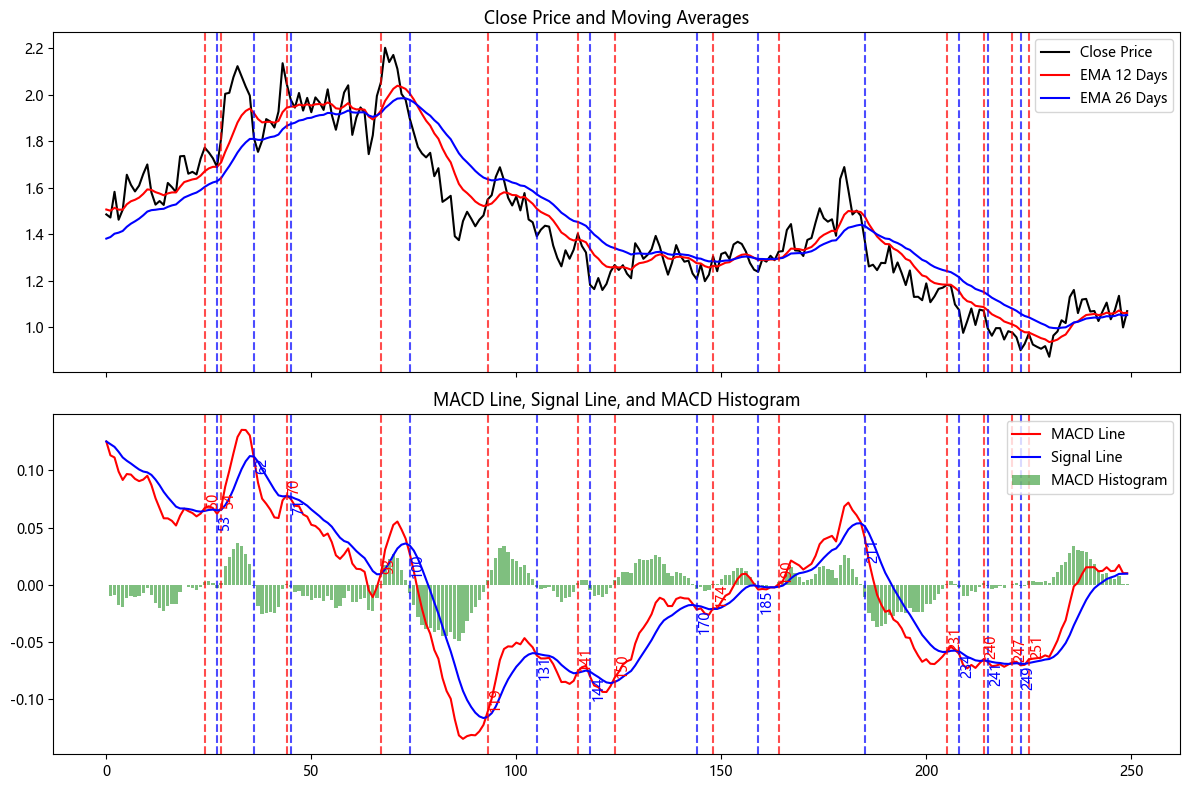

In [13]:
# 创建图像并设置两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 在第一个子图上绘制收盘价和两个均线
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax1.plot(df_plot.index, df_plot['EMA_12'], label='EMA 12 Days', color='red')
ax1.plot(df_plot.index, df_plot['EMA_26'], label='EMA 26 Days', color='blue')
ax1.set_title('Close Price and Moving Averages')
ax1.legend()

# 在第二个子图上绘制MACD线、信号线和MACD柱状图
ax2.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax2.plot(df_plot.index, df_plot['Signal_Line'], label='Signal Line', color='blue')
ax2.bar(df_plot.index, df_plot['MACD_Histogram'], label='MACD Histogram', color='green', alpha=0.5)
ax2.set_title('MACD Line, Signal Line, and MACD Histogram')
ax2.legend()

# 在两个子图中绘制交叉点的垂直虚线并标注日期
for idx, row in df_plot.iterrows():
    if row['Cross'] == 'crossover':
        ax1.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax2.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax2.text(idx, row['MACD_Line'], f'{row["index"]}', color='red', rotation=90, verticalalignment='bottom')
    elif row['Cross'] == 'crossunder':
        ax1.axvline(x=idx, color='blue', linestyle='--', alpha=0.7)
        ax2.axvline(x=idx, color='blue', linestyle='--', alpha=0.7)
        ax2.text(idx, row['MACD_Line'], f'{row["index"]}', color='blue', rotation=90, verticalalignment='top')

# 显示图像
plt.tight_layout()
plt.show()


# 背离

In [14]:
# 定义时间窗口长度变量
window_length = 5

# 高点

## 价格
### 1. 找到局部高点：收盘价高于前后两个交易日
df_plot['local_peak_price'] = (df_plot['close'] > df_plot['close'].shift(1)) & (df_plot['close'] > df_plot['close'].shift(-1))

### 2. 该高点需要高于过去window_length日的所有收盘价
df_plot['price_higher_past'] = df_plot['close'] > df_plot['close'].rolling(window=window_length, min_periods=1).max().shift(1)

### 应用所有条件来确认最终的高点
df_plot['final_peak_price'] = df_plot['local_peak_price'] & df_plot['price_higher_past']


## MACD线
### 1. 找到局部高点：MACD线高于前后两个交易日
df_plot['local_peak_macd'] = (df_plot['MACD_Line'] > df_plot['MACD_Line'].shift(1)) & (df_plot['MACD_Line'] > df_plot['MACD_Line'].shift(-1))

### 2. 该高点需要高于过去window_length日的所有MACD线值
df_plot['macd_higher_past'] = df_plot['MACD_Line'] > df_plot['MACD_Line'].rolling(window=window_length, min_periods=1).max().shift(1)

### 应用所有条件来确认最终的高点
df_plot['final_peak_macd'] = df_plot['local_peak_macd'] & df_plot['macd_higher_past']


# 低点

## 价格
### 1. 找到局部低点：收盘价低于前后两个交易日
df_plot['local_valley_price'] = (df_plot['close'] < df_plot['close'].shift(1)) & (df_plot['close'] < df_plot['close'].shift(-1))

### 2. 该低点需要低于过去window_length日的所有收盘价
df_plot['price_lower_past'] = df_plot['close'] < df_plot['close'].rolling(window=window_length, min_periods=1).min().shift(1)

### 应用所有条件来确认最终的低点
df_plot['final_valley_price'] = df_plot['local_valley_price'] & df_plot['price_lower_past']


## MACD线
### 1. 找到局部低点：MACD线低于前后两个交易日
df_plot['local_valley_macd'] = (df_plot['MACD_Line'] < df_plot['MACD_Line'].shift(1)) & (df_plot['MACD_Line'] < df_plot['MACD_Line'].shift(-1))

### 2. 该低点需要低于过去window_length日的所有MACD线值
df_plot['macd_lower_past'] = df_plot['MACD_Line'] < df_plot['MACD_Line'].rolling(window=window_length, min_periods=1).min().shift(1)

### 应用所有条件来确认最终的低点
df_plot['final_valley_macd'] = df_plot['local_valley_macd'] & df_plot['macd_lower_past']


# 输出更新后的df_plot
df_plot



,index,returns,close,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,Cross,local_peak_price,...,final_peak_price,local_peak_macd,macd_higher_past,final_peak_macd,local_valley_price,price_lower_past,final_valley_price,local_valley_macd,macd_lower_past,final_valley_macd
0,26,-0.076955,1.484981,1.506101,1.381087,0.125013,0.125119,-0.000106,nan,False,...,False,False,False,False,False,False,False,False,False,False
1,27,-0.008907,1.471755,1.500817,1.387804,0.113013,0.122698,-0.009685,nan,False,...,False,False,False,False,True,True,True,False,True,False
2,28,0.074962,1.582080,1.513319,1.402194,0.111124,0.120383,-0.009259,nan,True,...,True,False,False,False,False,False,False,False,True,False
3,29,-0.075755,1.462229,1.505459,1.406641,0.098817,0.116070,-0.017253,nan,False,...,False,False,False,False,True,True,True,False,True,False
4,30,0.029544,1.505428,1.505454,1.413959,0.091495,0.111155,-0.019660,nan,False,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,271,-0.064676,1.034658,1.058717,1.046798,0.011919,0.006384,0.005535,nan,False,...,False,False,False,False,True,False,False,True,False,False
246,272,0.037933,1.073906,1.061054,1.048806,0.012247,0.007556,0.004691,nan,False,...,False,False,False,False,False,False,False,False,False,False
247,273,0.057308,1.135450,1.072499,1.055224,0.017275,0.009500,0.007775,nan,True,...,True,True,True,True,False,False,False,False,False,False
248,274,-0.119788,0.999437,1.061259,1.051092,0.010167,0.009634,0.000534,nan,False,...,False,False,False,False,True,True,True,False,True,False


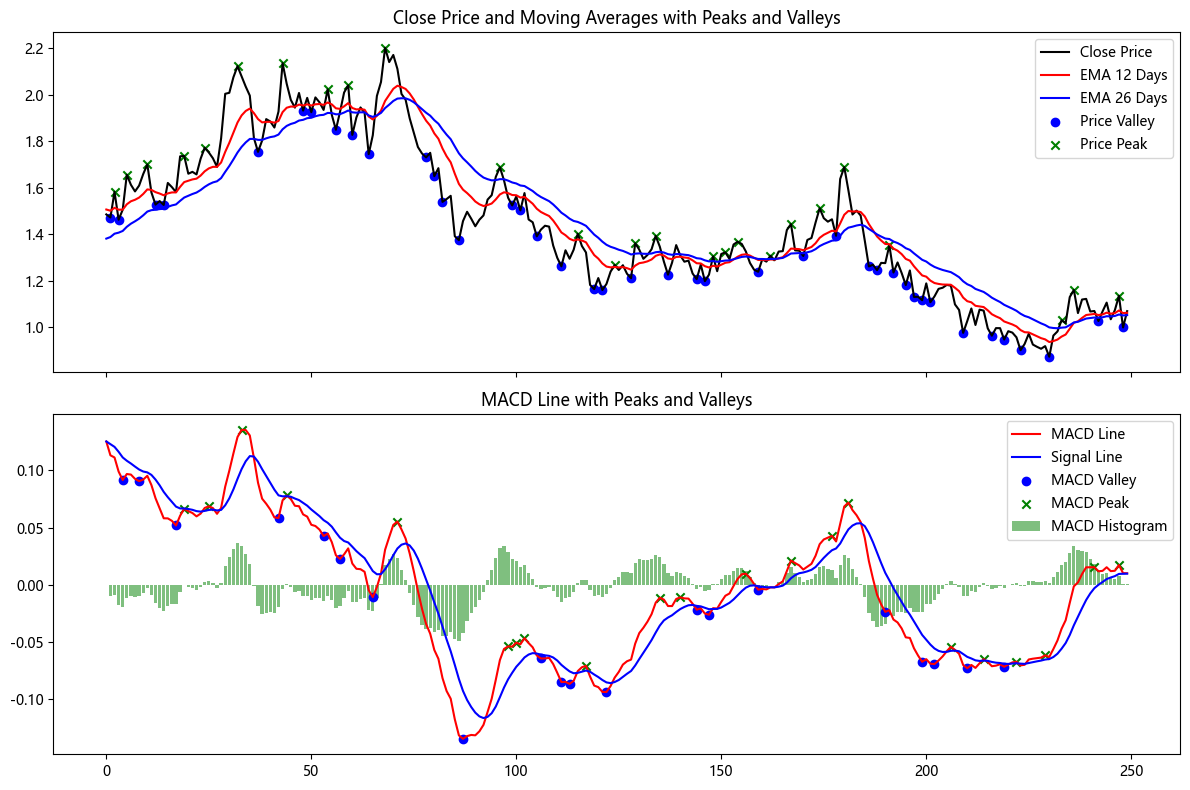

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 创建新的列用于存储价格的高点和低点，仅在高点或低点时保留收盘价，其余为NaN
df_plot['valley_marker'] = np.where(df_plot['final_valley_price'] == 1, df_plot['close'], np.nan)
df_plot['peak_marker'] = np.where(df_plot['final_peak_price'] == 1, df_plot['close'], np.nan)

# 创建新的列用于存储MACD线的高点和低点，仅在高点或低点时保留MACD线的值，其余为NaN
df_plot['macd_valley_marker'] = np.where(df_plot['final_valley_macd'] == 1, df_plot['MACD_Line'], np.nan)
df_plot['macd_peak_marker'] = np.where(df_plot['final_peak_macd'] == 1, df_plot['MACD_Line'], np.nan)

# 在第一个子图上绘制收盘价和两个均线
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax1.plot(df_plot.index, df_plot['EMA_12'], label='EMA 12 Days', color='red')
ax1.plot(df_plot.index, df_plot['EMA_26'], label='EMA 26 Days', color='blue')

# 使用散点图标记价格的高点和低点
ax1.scatter(df_plot.index, df_plot['valley_marker'], label='Price Valley', color='blue', marker='o')
ax1.scatter(df_plot.index, df_plot['peak_marker'], label='Price Peak', color='green', marker='x')

# 设置标题和图例
ax1.set_title('Close Price and Moving Averages with Peaks and Valleys')
ax1.legend()

# 在第二个子图上绘制MACD线、信号线和MACD柱状图
ax2.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax2.plot(df_plot.index, df_plot['Signal_Line'], label='Signal Line', color='blue')
ax2.bar(df_plot.index, df_plot['MACD_Histogram'], label='MACD Histogram', color='green', alpha=0.5)

# 使用散点图标记MACD线的高点和低点
ax2.scatter(df_plot.index, df_plot['macd_valley_marker'], label='MACD Valley', color='blue', marker='o')
ax2.scatter(df_plot.index, df_plot['macd_peak_marker'], label='MACD Peak', color='green', marker='x')

# 设置标题和图例
ax2.set_title('MACD Line with Peaks and Valleys')
ax2.legend()

# 自动调整子图布局
plt.tight_layout()
plt.show()

In [16]:
# 创建新的列以存储历史的高点和低点信息
df_plot['last_peak_price'] = df_plot['close'].where(df_plot['final_peak_price']).ffill()
df_plot['last_valley_price'] = df_plot['close'].where(df_plot['final_valley_price']).ffill()
df_plot['last_peak_dif'] = df_plot['MACD_Line'].where(df_plot['final_peak_macd']).ffill()
df_plot['last_valley_dif'] = df_plot['MACD_Line'].where(df_plot['final_valley_macd']).ffill()

# 判断当前价格是否创下新高或新低
df_plot['price_new_high'] = df_plot['close'] > df_plot['close'].rolling(window=10, min_periods=1).max().shift(1)
df_plot['price_new_low'] = df_plot['close'] < df_plot['close'].rolling(window=10, min_periods=1).min().shift(1)

# 顶背离条件
cond1_top = df_plot['price_new_high'] == True
cond2_top = df_plot['close'] > df_plot['last_peak_price']
cond3_top = df_plot['MACD_Line'] < df_plot['last_peak_dif']

# 底背离条件
cond1_bottom = df_plot['price_new_low'] == True
cond2_bottom = df_plot['close'] < df_plot['last_valley_price']
cond3_bottom = df_plot['MACD_Line'] > df_plot['last_valley_dif']

# 添加顶背离和底背离的信号
df_plot['signal'] = ''
df_plot.loc[cond1_top & cond2_top & cond3_top, 'signal'] = '顶背离'
df_plot.loc[cond1_bottom & cond2_bottom & cond3_bottom, 'signal'] = '底背离'

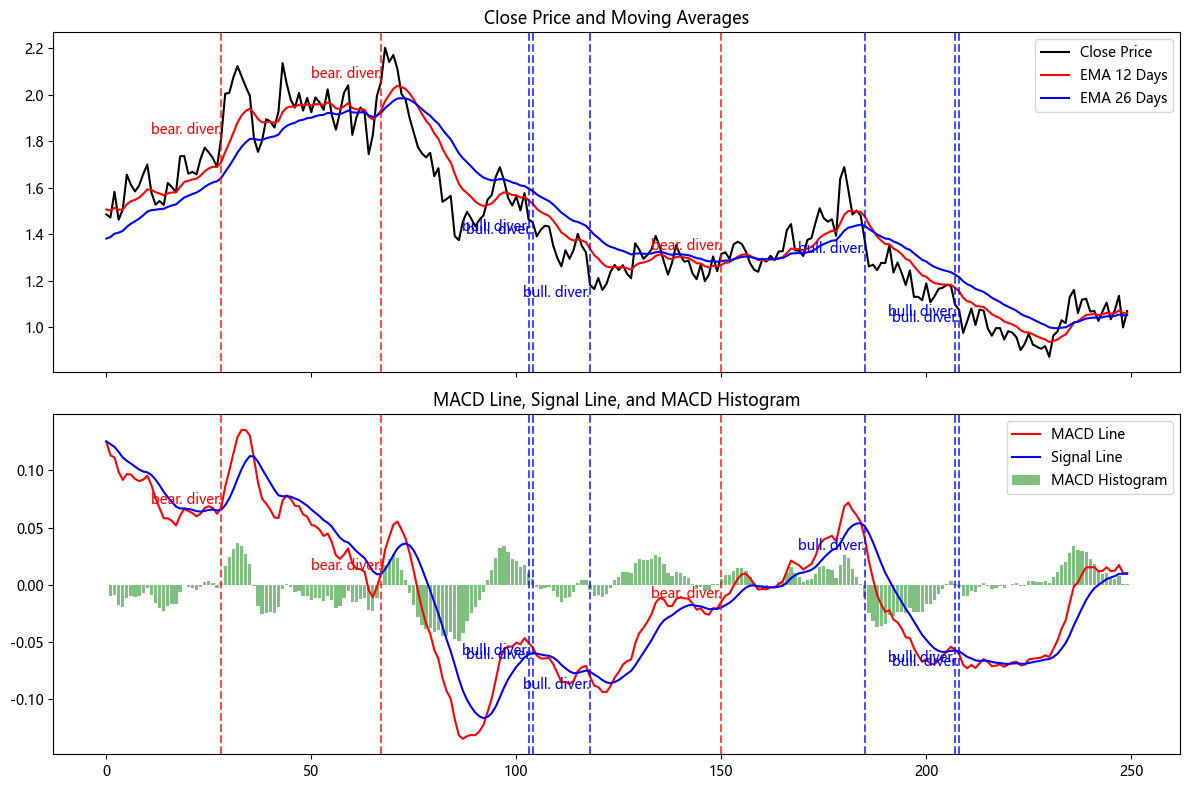

In [17]:
import matplotlib.pyplot as plt

# 创建图像并设置两个子图，基于更新后的100天数据绘制
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 在第一个子图上绘制收盘价和两个均线
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax1.plot(df_plot.index, df_plot['EMA_12'], label='EMA 12 Days', color='red')
ax1.plot(df_plot.index, df_plot['EMA_26'], label='EMA 26 Days', color='blue')
ax1.set_title('Close Price and Moving Averages')
ax1.legend()

# 在第二个子图上绘制MACD线、信号线和MACD柱状图
ax2.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax2.plot(df_plot.index, df_plot['Signal_Line'], label='Signal Line', color='blue')
ax2.bar(df_plot.index, df_plot['MACD_Histogram'], label='MACD Histogram', color='green', alpha=0.5)
ax2.set_title('MACD Line, Signal Line, and MACD Histogram')
ax2.legend()

# 在两个子图中标记背离情况 
for idx, row in df_plot.iterrows():
    if row['signal'] == '顶背离':
        # 在价格图中绘制竖线表示背离
        ax1.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax1.text(idx, row['close'], 'bear. diver.', color='red', verticalalignment='bottom', horizontalalignment='right')
        # 在MACD图中绘制竖线表示背离
        ax2.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax2.text(idx, row['MACD_Line'], 'bear. diver.', color='red', verticalalignment='bottom', horizontalalignment='right')

    elif row['signal'] == '底背离':
        # 在价格图中绘制竖线表示背离
        ax1.axvline(x=idx, color='blue', linestyle='--', alpha=0.7)
        ax1.text(idx, row['close'], 'bull. diver.', color='blue', verticalalignment='top', horizontalalignment='right')
        # 在MACD图中绘制竖线表示背离
        ax2.axvline(x=idx, color='blue', linestyle='--', alpha=0.7)
        ax2.text(idx, row['MACD_Line'], 'bull. diver.', color='blue', verticalalignment='top', horizontalalignment='right')

# 显示图像
plt.tight_layout()
plt.show()


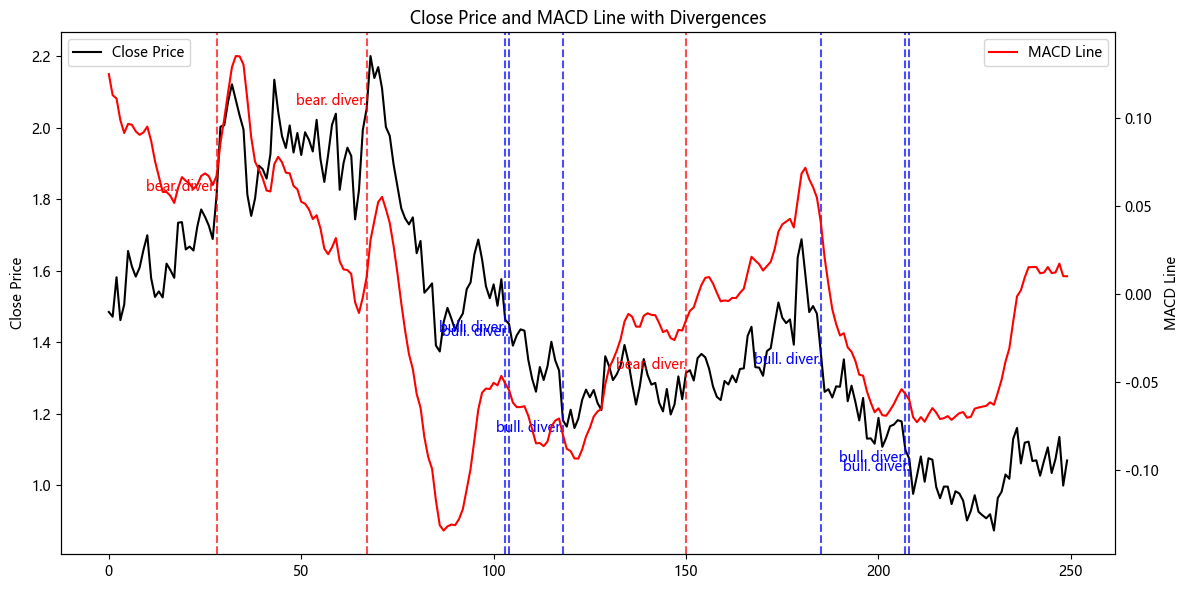

In [18]:
# 创建一个新的图像，带有双坐标轴，显示价格和MACD线
fig, ax3 = plt.subplots(1, 1, figsize=(12, 6))

# 在左边的坐标轴上绘制收盘价
ax3.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax3.set_ylabel('Close Price')
ax3.set_title('Close Price and MACD Line with Divergences')

# 创建一个共享x轴但独立y轴的右边坐标轴，用于绘制MACD线
ax4 = ax3.twinx()
ax4.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax4.set_ylabel('MACD Line')

# 在图中标记背离情况 
for idx, row in df_plot.iterrows():
    if row['signal'] == '顶背离':
        # 在图中绘制竖线表示背离
        ax3.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax3.text(idx, row['close'], 'bear. diver.', color='red', verticalalignment='bottom', horizontalalignment='right')

    elif row['signal'] == '底背离':
        # 在图中绘制竖线表示背离
        ax3.axvline(x=idx, color='blue', linestyle='--', alpha=0.7)
        ax3.text(idx, row['close'], 'bull. diver.', color='blue', verticalalignment='top', horizontalalignment='right')

# 添加图例
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# 显示图像
plt.tight_layout()
plt.show()


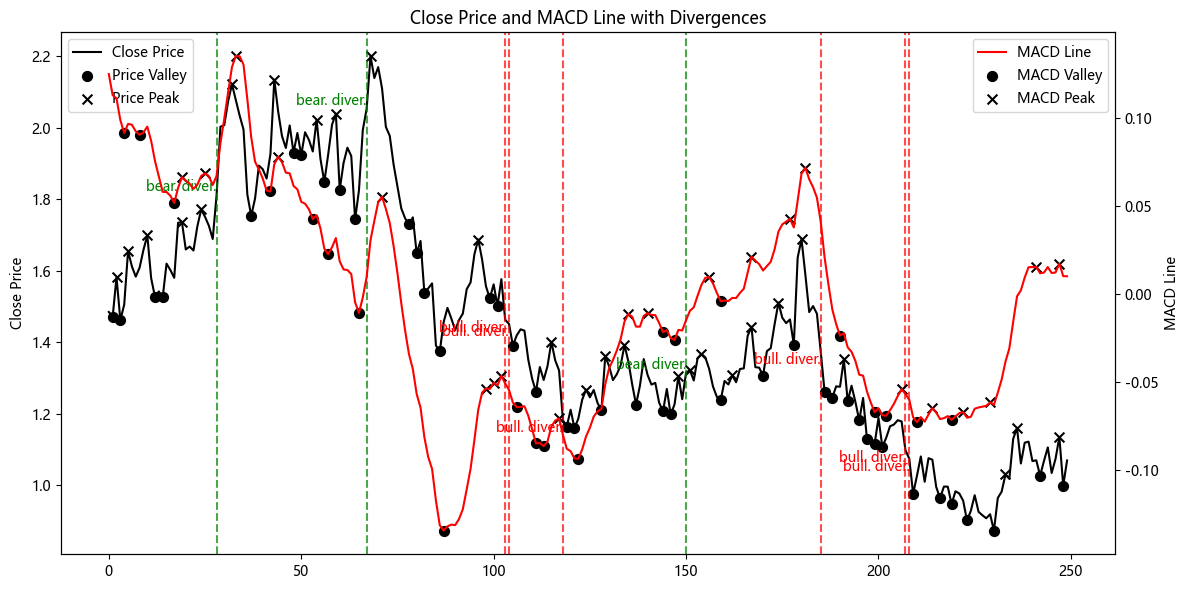

In [23]:
# 创建一个新的图像，带有双坐标轴，显示价格和MACD线
fig, ax3 = plt.subplots(1, 1, figsize=(12, 6))

# 在左边的坐标轴上绘制收盘价
ax3.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')
ax3.set_ylabel('Close Price')
ax3.set_title('Close Price and MACD Line with Divergences')

# 创建一个共享x轴但独立y轴的右边坐标轴，用于绘制MACD线
ax4 = ax3.twinx()
ax4.plot(df_plot.index, df_plot['MACD_Line'], label='MACD Line', color='red')
ax4.set_ylabel('MACD Line')

# 使用不同的形状在价格和MACD线上标记出高点和低点

# 在价格线标记低点（使用圆形 'o'）和高点（使用叉形 'x'）
ax3.scatter(df_plot.index, df_plot['valley_marker'], label='Price Valley', marker='o', color='black', s=50)
ax3.scatter(df_plot.index, df_plot['peak_marker'], label='Price Peak', marker='x', color='black', s=50)

# 在MACD线上标记低点（使用圆形 'o'）和高点（使用叉形 'x'）
ax4.scatter(df_plot.index, df_plot['macd_valley_marker'], label='MACD Valley', marker='o', color='black', s=50)
ax4.scatter(df_plot.index, df_plot['macd_peak_marker'], label='MACD Peak', marker='x', color='black', s=50)

# 在图中标记背离情况
for idx, row in df_plot.iterrows():
    if row['signal'] == '顶背离':
        # 在图中绘制竖线表示背离
        ax3.axvline(x=idx, color='green', linestyle='--', alpha=0.7)
        ax3.text(idx, row['close'], 'bear. diver.', color='green', verticalalignment='bottom', horizontalalignment='right')

    elif row['signal'] == '底背离':
        # 在图中绘制竖线表示背离
        ax3.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        ax3.text(idx, row['close'], 'bull. diver.', color='red', verticalalignment='top', horizontalalignment='right')

# 添加图例
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# 显示图像
plt.tight_layout()
plt.show()


# 数据处理总结为函数

In [ ]:
def process_peaks_valleys(df_plot, window_length):
    '''
    该函数用于处理股票的收盘价和MACD线的高点（peak）和低点（valley）。
    它通过以下步骤来完成：
    
    1. 识别局部高点和低点：收盘价或MACD线大于/小于前后两个交易日的值。
    2. 对比过去的窗口长度天数内的最高/最低值，确认高点或低点。
    3. 存储历史的高点和低点信息。
    4. 通过价格和MACD的高低点，判断是否形成顶背离或底背离信号。

    参数：
    df_plot: 包含收盘价和MACD线的DataFrame
    window_length: 用于滚动计算的时间窗口长度
    
    返回：
    处理后的df_plot，包含高点、低点、顶背离和底背离的信号
    '''
    
    # 高点处理

    ## 价格
    # 1. 找到局部高点：收盘价高于前后两个交易日
    df_plot['local_peak_price'] = (df_plot['close'] > df_plot['close'].shift(1)) & (df_plot['close'] > df_plot['close'].shift(-1))

    # 2. 该高点需要高于过去window_length日的所有收盘价
    df_plot['price_higher_past'] = df_plot['close'] > df_plot['close'].rolling(window=window_length, min_periods=1).max().shift(1)

    # 3. 应用所有条件来确认最终的高点
    df_plot['final_peak_price'] = df_plot['local_peak_price'] & df_plot['price_higher_past']


    ## MACD线
    # 1. 找到局部高点：MACD线高于前后两个交易日
    df_plot['local_peak_macd'] = (df_plot['MACD_Line'] > df_plot['MACD_Line'].shift(1)) & (df_plot['MACD_Line'] > df_plot['MACD_Line'].shift(-1))

    # 2. 该高点需要高于过去window_length日的所有MACD线值
    df_plot['macd_higher_past'] = df_plot['MACD_Line'] > df_plot['MACD_Line'].rolling(window=window_length, min_periods=1).max().shift(1)

    # 3. 应用所有条件来确认最终的高点
    df_plot['final_peak_macd'] = df_plot['local_peak_macd'] & df_plot['macd_higher_past']


    # 低点处理

    ## 价格
    # 1. 找到局部低点：收盘价低于前后两个交易日
    df_plot['local_valley_price'] = (df_plot['close'] < df_plot['close'].shift(1)) & (df_plot['close'] < df_plot['close'].shift(-1))

    # 2. 该低点需要低于过去window_length日的所有收盘价
    df_plot['price_lower_past'] = df_plot['close'] < df_plot['close'].rolling(window=window_length, min_periods=1).min().shift(1)

    # 3. 应用所有条件来确认最终的低点
    df_plot['final_valley_price'] = df_plot['local_valley_price'] & df_plot['price_lower_past']


    ## MACD线
    # 1. 找到局部低点：MACD线低于前后两个交易日
    df_plot['local_valley_macd'] = (df_plot['MACD_Line'] < df_plot['MACD_Line'].shift(1)) & (df_plot['MACD_Line'] < df_plot['MACD_Line'].shift(-1))

    # 2. 该低点需要低于过去window_length日的所有MACD线值
    df_plot['macd_lower_past'] = df_plot['MACD_Line'] < df_plot['MACD_Line'].rolling(window=window_length, min_periods=1).min().shift(1)

    # 3. 应用所有条件来确认最终的低点
    df_plot['final_valley_macd'] = df_plot['local_valley_macd'] & df_plot['macd_lower_past']


    # 创建新的列以存储历史的高点和低点信息
    df_plot['last_peak_price'] = df_plot['close'].where(df_plot['final_peak_price']).ffill()
    df_plot['last_valley_price'] = df_plot['close'].where(df_plot['final_valley_price']).ffill()
    df_plot['last_peak_dif'] = df_plot['MACD_Line'].where(df_plot['final_peak_macd']).ffill()
    df_plot['last_valley_dif'] = df_plot['MACD_Line'].where(df_plot['final_valley_macd']).ffill()

    # 判断当前价格是否创下新高或新低
    df_plot['price_new_high'] = df_plot['close'] > df_plot['close'].rolling(window=10, min_periods=1).max().shift(1)
    df_plot['price_new_low'] = df_plot['close'] < df_plot['close'].rolling(window=10, min_periods=1).min().shift(1)

    # 顶背离条件
    cond1_top = df_plot['price_new_high'] == True
    cond2_top = df_plot['close'] > df_plot['last_peak_price']
    cond3_top = df_plot['MACD_Line'] < df_plot['last_peak_dif']

    # 底背离条件
    cond1_bottom = df_plot['price_new_low'] == True
    cond2_bottom = df_plot['close'] < df_plot['last_valley_price']
    cond3_bottom = df_plot['MACD_Line'] > df_plot['last_valley_dif']

    # 添加顶背离和底背离的信号
    df_plot['signal'] = ''
    df_plot.loc[cond1_top & cond2_top & cond3_top, 'signal'] = '顶背离'
    df_plot.loc[cond1_bottom & cond2_bottom & cond3_bottom, 'signal'] = '底背离'

    return df_plot
